импорт библиотек

In [29]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import phik

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import xgboost as xgb
from xgboost import XGBClassifier



# Загрузка и подготовка данных

In [30]:
lstm_embs = pd.read_csv('../data/ts_lstm_embeddings.csv')
lstm_embs.head()

,student_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,9431,0.028173,-0.059907,-0.071333,0.049000,-0.058226,-0.051722,0.041741,-0.000571,0.066269,...,0.007996,0.001751,0.071754,-0.011652,0.018209,0.030214,0.002476,0.017538,0.010546,-0.000625
1,26090,0.025742,-0.061791,-0.073573,0.052954,-0.062950,-0.054274,0.045108,0.002962,0.069635,...,0.006690,0.004513,0.067529,-0.012606,0.021313,0.035239,0.004350,0.010830,0.012770,0.001926
2,36478,0.024638,-0.062649,-0.074594,0.054759,-0.065101,-0.055442,0.046645,0.004576,0.071166,...,0.006093,0.005769,0.065612,-0.013040,0.022723,0.037524,0.005204,0.007773,0.013779,0.003088
3,37987,0.024347,-0.062875,-0.074865,0.055237,-0.065669,-0.055751,0.047052,0.005003,0.071571,...,0.005935,0.006100,0.065107,-0.013154,0.023095,0.038127,0.005430,0.006965,0.014045,0.003395
4,78724,0.029430,-0.058934,-0.070180,0.046965,-0.055788,-0.050412,0.040008,-0.002387,0.064532,...,0.008667,0.000323,0.073942,-0.011158,0.016603,0.027618,0.001511,0.020994,0.009393,-0.001942


In [31]:
features = pd.read_csv('../data/features.csv')
features.head()

,student_id,is_diploma,is_resume,is_refund,tu,days_to_first_dropout,first_dropout_lesson_Business/Logic,first_dropout_lesson_Excel,first_dropout_lesson_Homework/Test,first_dropout_lesson_Intro,first_dropout_lesson_Other,first_dropout_lesson_Projects,first_dropout_lesson_SQL/Python,last_dropout_lesson_Business/Logic,last_dropout_lesson_Excel,last_dropout_lesson_Homework/Test,last_dropout_lesson_Intro,last_dropout_lesson_Other,last_dropout_lesson_Projects,last_dropout_lesson_SQL/Python
0,22530050,0,0,0,0,35.0,False,True,False,False,False,False,False,False,False,False,False,False,False,True
1,20483393,0,0,0,0,28.0,False,False,False,False,True,False,False,False,False,False,False,True,False,False
2,21048237,0,0,0,0,56.0,True,False,False,False,False,False,False,False,False,False,False,True,False,False
3,22455198,1,1,0,1,98.0,True,False,False,False,False,False,False,False,False,False,False,False,True,False
4,20403558,1,1,0,1,98.0,False,True,False,False,False,False,False,False,False,False,False,False,True,False


In [32]:
features_and_embs = pd.merge(lstm_embs, features, on='student_id')
features_and_embs.drop(columns=['student_id'], inplace=True)
features_and_embs.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,first_dropout_lesson_Other,first_dropout_lesson_Projects,first_dropout_lesson_SQL/Python,last_dropout_lesson_Business/Logic,last_dropout_lesson_Excel,last_dropout_lesson_Homework/Test,last_dropout_lesson_Intro,last_dropout_lesson_Other,last_dropout_lesson_Projects,last_dropout_lesson_SQL/Python
0,0.028173,-0.059907,-0.071333,0.049000,-0.058226,-0.051722,0.041741,-0.000571,0.066269,0.023966,...,False,False,False,False,False,False,False,False,False,False
1,0.025742,-0.061791,-0.073573,0.052954,-0.062950,-0.054274,0.045108,0.002962,0.069635,0.027896,...,False,False,False,False,False,False,False,False,False,True
2,0.024638,-0.062649,-0.074594,0.054759,-0.065101,-0.055442,0.046645,0.004576,0.071166,0.029678,...,False,False,False,False,False,False,False,True,False,False
3,0.024638,-0.062649,-0.074594,0.054759,-0.065101,-0.055442,0.046645,0.004576,0.071166,0.029678,...,False,False,False,False,False,False,False,True,False,False
4,0.024347,-0.062875,-0.074865,0.055237,-0.065669,-0.055751,0.047052,0.005003,0.071571,0.030148,...,False,False,False,False,False,False,False,True,False,False


# Эксперимент 1: объединение признаков и векторов, извлечённых lstm из временных рядов посещаемости

In [33]:
X = features_and_embs.drop(columns='is_refund')
y = features_and_embs['is_refund']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (2069, 146) (2069,)
Test: (518, 146) (518,)


In [34]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [35]:
print(f'Размерность тренировочной выборки после сэмплирования: {X_train.shape}')
print(f'Баланс классов после сэмплирования:\n{y_train.value_counts()}')

Размерность тренировочной выборки после сэмплирования: (3692, 146)
Баланс классов после сэмплирования:
is_refund
0    1846
1    1846
Name: count, dtype: int64


In [36]:
num_features = []
for col in features_and_embs.columns:
    if 'emb' in col or 'days' in col:
        num_features.append(col)

scaler = StandardScaler()

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

## Модель логистической регрессии

In [37]:
logistic_regression = LogisticRegression(C=1)
logistic_regression.fit(X_train, y_train)
y_pred_train_lr = logistic_regression.predict(X_train)
y_pred_test_lr = logistic_regression.predict(X_test)
print(f'Метрики train\n{metrics.classification_report(y_train, y_pred_train_lr)}')
print(f'Метрики test\n{metrics.classification_report(y_test, y_pred_test_lr)}')


Метрики train
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1846
           1       0.84      0.96      0.90      1846

    accuracy                           0.89      3692
   macro avg       0.90      0.89      0.89      3692
weighted avg       0.90      0.89      0.89      3692

Метрики test
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       464
           1       0.36      0.83      0.50        54

    accuracy                           0.83       518
   macro avg       0.67      0.83      0.70       518
weighted avg       0.91      0.83      0.86       518



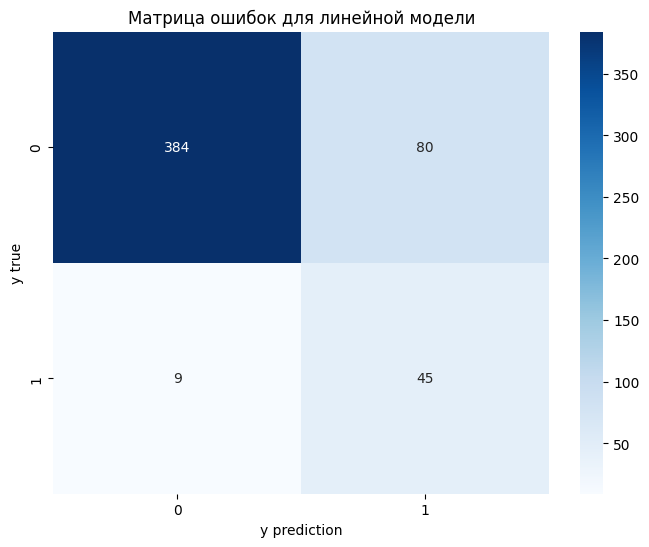

In [38]:
confusion_matrix1 = metrics.confusion_matrix(y_test, y_pred_test_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix1, annot=True, fmt='', cmap='Blues')
plt.title('Матрица ошибок для линейной модели')
plt.xlabel('y prediction')
plt.ylabel('y true')
plt.show()

## XGboost

In [39]:
param_grid = {
    'n_estimators': [10, 25, 50],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [40]:
best_model_xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Лучшая метрика f1 на обучающем наборе данных:", grid_search.best_score_) 


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Лучшая метрика f1 на обучающем наборе данных: 0.8867427921343172


In [41]:
y_pred_train_xgb = best_model_xgb.predict(X_train)
y_pred_test_xgb = best_model_xgb.predict(X_test)
print(f'Метрики train\n{metrics.classification_report(y_train, y_pred_train_xgb)}')
print(f'Метрики test\n{metrics.classification_report(y_test, y_pred_test_xgb)}')


Метрики train
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1846
           1       0.85      0.96      0.90      1846

    accuracy                           0.89      3692
   macro avg       0.90      0.89      0.89      3692
weighted avg       0.90      0.89      0.89      3692

Метрики test
              precision    recall  f1-score   support

           0       0.97      0.83      0.90       464
           1       0.36      0.81      0.50        54

    accuracy                           0.83       518
   macro avg       0.67      0.82      0.70       518
weighted avg       0.91      0.83      0.86       518



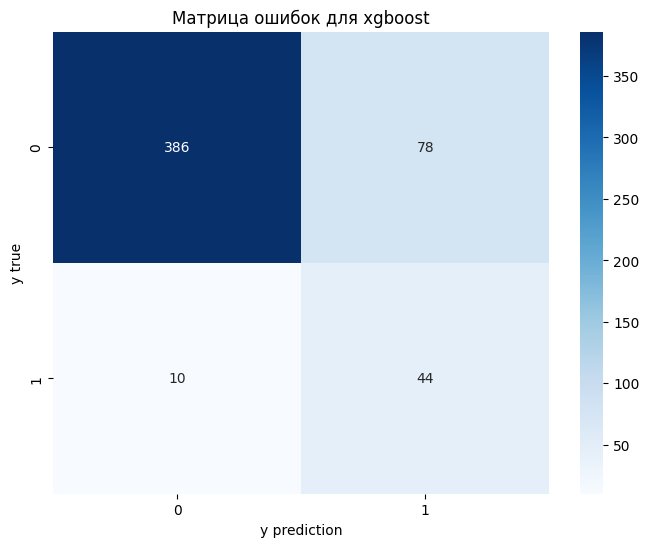

In [42]:
confusion_matrix2 = metrics.confusion_matrix(y_test, y_pred_test_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix2, annot=True, fmt='', cmap='Blues')
plt.title('Матрица ошибок для xgboost')
plt.xlabel('y prediction')
plt.ylabel('y true')
plt.show()

# Эксперимент 2: объединение признаков и добавление нового: вероятность оттока, полученная из lstm временных рядов

In [43]:
lstm_probs = pd.read_csv('../data/ts_lstm_refund_prob.csv')
features_and_probs = pd.merge(lstm_probs, features, on='student_id')
features_and_probs.drop(columns=['student_id'], inplace=True)
features_and_probs.head()

,refund_prob,is_diploma,is_resume,is_refund,tu,days_to_first_dropout,first_dropout_lesson_Business/Logic,first_dropout_lesson_Excel,first_dropout_lesson_Homework/Test,first_dropout_lesson_Intro,first_dropout_lesson_Other,first_dropout_lesson_Projects,first_dropout_lesson_SQL/Python,last_dropout_lesson_Business/Logic,last_dropout_lesson_Excel,last_dropout_lesson_Homework/Test,last_dropout_lesson_Intro,last_dropout_lesson_Other,last_dropout_lesson_Projects,last_dropout_lesson_SQL/Python
0,0.114276,1,0,0,1,70.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False
1,0.231850,0,0,0,0,11.0,False,True,False,False,False,False,False,False,False,False,False,False,False,True
2,0.307584,0,0,1,0,7.0,False,False,False,True,False,False,False,False,False,False,False,True,False,False
3,0.307584,0,0,1,0,21.0,True,False,False,False,False,False,False,False,False,False,False,True,False,False
4,0.329730,0,0,0,0,11.0,False,True,False,False,False,False,False,False,False,False,False,True,False,False


In [44]:
X = features_and_probs.drop(columns='is_refund')
y = features_and_probs['is_refund']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (2069, 19) (2069,)
Test: (518, 19) (518,)


In [45]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [46]:
print(f'Размерность тренировочной выборки после сэмплирования: {X_train.shape}')
print(f'Баланс классов после сэмплирования:\n{y_train.value_counts()}')

Размерность тренировочной выборки после сэмплирования: (3692, 19)
Баланс классов после сэмплирования:
is_refund
0    1846
1    1846
Name: count, dtype: int64


In [47]:
num_features = []
for col in features_and_probs.columns:
    if 'emb' in col or 'days' in col:
        num_features.append(col)

scaler = StandardScaler()

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

In [48]:
logistic_regression = LogisticRegression(C=1)
logistic_regression.fit(X_train, y_train)
y_pred_train_lr = logistic_regression.predict(X_train)
y_pred_test_lr = logistic_regression.predict(X_test)
print(f'Метрики train\n{metrics.classification_report(y_train, y_pred_train_lr)}')
print(f'Метрики test\n{metrics.classification_report(y_test, y_pred_test_lr)}')


Метрики train
              precision    recall  f1-score   support

           0       0.95      0.78      0.85      1846
           1       0.81      0.96      0.88      1846

    accuracy                           0.87      3692
   macro avg       0.88      0.87      0.87      3692
weighted avg       0.88      0.87      0.87      3692

Метрики test
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       464
           1       0.35      0.91      0.51        54

    accuracy                           0.82       518
   macro avg       0.67      0.86      0.70       518
weighted avg       0.92      0.82      0.85       518



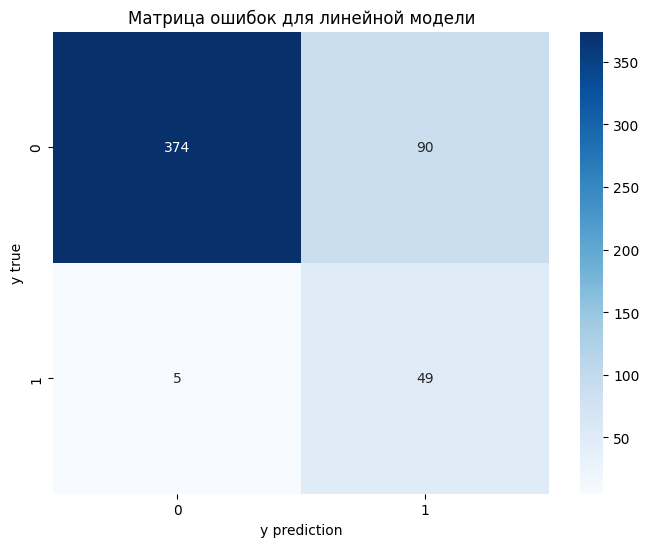

In [49]:
confusion_matrix3 = metrics.confusion_matrix(y_test, y_pred_test_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix3, annot=True, fmt='', cmap='Blues')
plt.title('Матрица ошибок для линейной модели')
plt.xlabel('y prediction')
plt.ylabel('y true')
plt.show()

In [50]:
param_grid = {
    'n_estimators': [10, 25, 50],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [51]:
best_model_xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Лучшая метрика f1 на обучающем наборе данных:", grid_search.best_score_) 


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Лучшая метрика f1 на обучающем наборе данных: 0.8829256773370331


In [52]:
y_pred_train_xgb = best_model_xgb.predict(X_train)
y_pred_test_xgb = best_model_xgb.predict(X_test)
print(f'Метрики train\n{metrics.classification_report(y_train, y_pred_train_xgb)}')
print(f'Метрики test\n{metrics.classification_report(y_test, y_pred_test_xgb)}')


Метрики train
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1846
           1       0.85      0.96      0.90      1846

    accuracy                           0.89      3692
   macro avg       0.90      0.89      0.89      3692
weighted avg       0.90      0.89      0.89      3692

Метрики test
              precision    recall  f1-score   support

           0       0.97      0.83      0.90       464
           1       0.36      0.81      0.50        54

    accuracy                           0.83       518
   macro avg       0.67      0.82      0.70       518
weighted avg       0.91      0.83      0.86       518



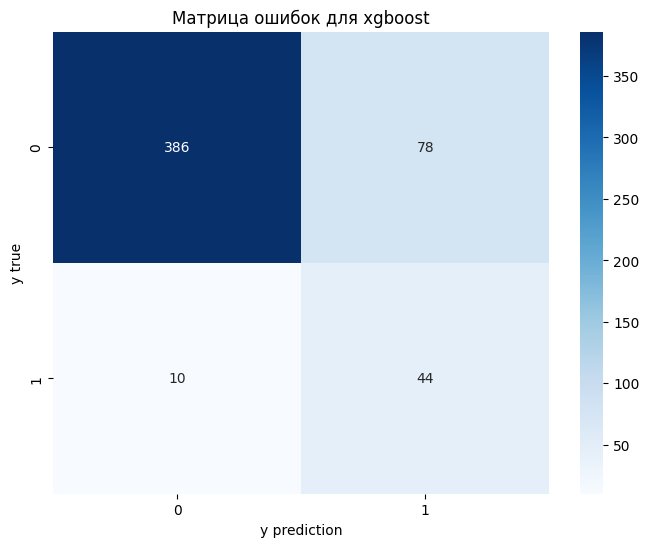

In [53]:
confusion_matrix4 = metrics.confusion_matrix(y_test, y_pred_test_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix4, annot=True, fmt='', cmap='Blues')
plt.title('Матрица ошибок для xgboost')
plt.xlabel('y prediction')
plt.ylabel('y true')
plt.show()


# Результаты

In [58]:
results = pd.DataFrame(columns=['experiment', 'model', 'accuracy', 'precision', 'recall', 'f1'])
lr_1 = {'experiment': 1, 'model': 'log reg', 'accuracy': 0.83, 'precision': 0.67, 'recall': 0.83, 'f1': 0.70}
results.loc[len(results)] = lr_1
xgb_1 = {'experiment': 1, 'model': 'xgb', 'accuracy': 0.83, 'precision': 0.67, 'recall': 0.82, 'f1': 0.70}
results.loc[len(results)] = xgb_1
lr_2 = {'experiment': 2, 'model': 'log reg', 'accuracy': 0.82, 'precision': 0.67, 'recall': 0.86, 'f1': 0.70}
results.loc[len(results)] = lr_2
xgb_2 = {'experiment': 2, 'model': 'xgb', 'accuracy': 0.83, 'precision': 0.67, 'recall': 0.82, 'f1': 0.70}
results.loc[len(results)] = xgb_2

results 

,experiment,model,accuracy,precision,recall,f1
0,1,log reg,0.83,0.67,0.83,0.7
1,1,xgb,0.83,0.67,0.82,0.7
2,2,log reg,0.82,0.67,0.86,0.7
3,2,xgb,0.83,0.67,0.82,0.7
